Worked with:
- Trevor Mathisen

- Viet Nguyen

1. Download startup failure dataset and its description.
2. Perform standard EDA to get familiar with the dataset.

In [1]:
import pandas as pd
from pandas import set_option
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from numpy import set_printoptions, log, argmax
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


In [36]:
filename = 'startupfailures.csv'
data = read_csv(filename)
set_printoptions(precision=3)
data = data.dropna()
print(data.isnull().sum())

Name                      0
Sector                    0
Years of Operation        0
What They Did             0
How Much They Raised      0
Why They Failed           0
Takeaway                  0
Giants                    0
No Budget                 0
Competition               0
Poor Market Fit           0
Acquisition Stagnation    0
Platform Dependency       0
Monetization Failure      0
Niche Limits              0
Execution Flaws           0
Trend Shifts              0
Toxicity/Trust Issues     0
Regulatory Pressure       0
Overhype                  0
dtype: int64


In [4]:
print(data.head(5))

             Name                 Sector Years of Operation  \
0           Avant  Finance and Insurance          2012-2023   
1         Bitpass  Finance and Insurance          2002-2008   
2  Cake Financial  Finance and Insurance          2006-2011   
3          Circle  Finance and Insurance          2013-2023   
4   Clarity Money  Finance and Insurance          2016-2022   

                    What They Did How Much They Raised  \
0           Online personal loans                $655M   
1          Micropayments platform                  $2M   
2         Portfolio tracking tool                  $3M   
3  Crypto payments and stablecoin                $500M   
4            Personal finance app                 $11M   

                           Why They Failed                     Takeaway  \
0    Lost to LendingClub and high defaults   Lending needs risk balance   
1          Lost to PayPal and low adoption  Micropayments need mass use   
2       Lost to Mint and sold to TradeKing     

In [37]:
# Years of operation is a string like '2012-2023'. We need to convert this to three columns: the abs value of the difference in the current column and two new columns: start year, end year.
data['start_year'] = data['Years of Operation'].str.split("-", expand=True)[0].astype(int)
data['end_year'] = data['Years of Operation'].str.split("-", expand=True)[1].astype(int)
data = data.drop(columns=['Years of Operation'])
data['Years of Operation'] = data['end_year'] - data['start_year']
data = data.drop(columns=['start_year', 'end_year', "What They Did", "Why They Failed", "Takeaway", "Name"])
print(data.isnull().sum())
print(data.head(5))

Sector                    0
How Much They Raised      0
Giants                    0
No Budget                 0
Competition               0
Poor Market Fit           0
Acquisition Stagnation    0
Platform Dependency       0
Monetization Failure      0
Niche Limits              0
Execution Flaws           0
Trend Shifts              0
Toxicity/Trust Issues     0
Regulatory Pressure       0
Overhype                  0
Years of Operation        0
dtype: int64
                  Sector How Much They Raised  Giants  No Budget  Competition  \
0  Finance and Insurance                $655M       1          1            1   
1  Finance and Insurance                  $2M       1          0            1   
2  Finance and Insurance                  $3M       1          0            1   
3  Finance and Insurance                $500M       1          0            1   
4  Finance and Insurance                 $11M       1          0            1   

   Poor Market Fit  Acquisition Stagnation  Platform

In [38]:
# Convert Overhype to an integer
data['Overhype'] = data['Overhype'].astype(int)
# Remove $ and M from How Much They Raised
import re

def extract_number(text):
    if pd.isna(text):
        return float('nan')
    # Extract the first number in the string (works for cases like "1.7B (Dropbox)" or "0 (SoFi-funded)")
    match = re.search(r'(\d+\.?\d*)', str(text))
    if match:
        number = float(match.group(1))
        # Handle B/M multipliers
        if 'B' in text:
            number *= 1000  # Convert billions to millions
        return number
    return float('nan')

# Apply the function to clean the column
data['How Much They Raised'] = data['How Much They Raised'].apply(extract_number)

print(data.head(5))

                  Sector  How Much They Raised  Giants  No Budget  \
0  Finance and Insurance                 655.0       1          1   
1  Finance and Insurance                   2.0       1          0   
2  Finance and Insurance                   3.0       1          0   
3  Finance and Insurance                 500.0       1          0   
4  Finance and Insurance                  11.0       1          0   

   Competition  Poor Market Fit  Acquisition Stagnation  Platform Dependency  \
0            1                0                       0                    0   
1            1                1                       0                    0   
2            1                0                       1                    0   
3            1                0                       0                    0   
4            1                0                       1                    0   

   Monetization Failure  Niche Limits  Execution Flaws  Trend Shifts  \
0                     0         

In [39]:
label_encoder = LabelEncoder()
data["Sector"] = label_encoder.fit_transform(data["Sector"])

3. Use the sample code for the Ensemble classifier and modify it to work with the Startup
dataset.

In [42]:
X = data.drop('Overhype', axis=1)
Y = data['Overhype']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

4. Compare the performance a decision tree, bagging classifier, random forest and a
boosting classifier using all default settings and configuration used in the sample code.

Bagging Classifier Accuracy: 1.0000
Decision Tree Classifier Accuracy: 1.0000
Random Forest Classifier Accuracy: 1.0000
AdaBoost Classifier Accuracy: 1.0000


/tmp/ipykernel_13045/398291460.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette="viridis")


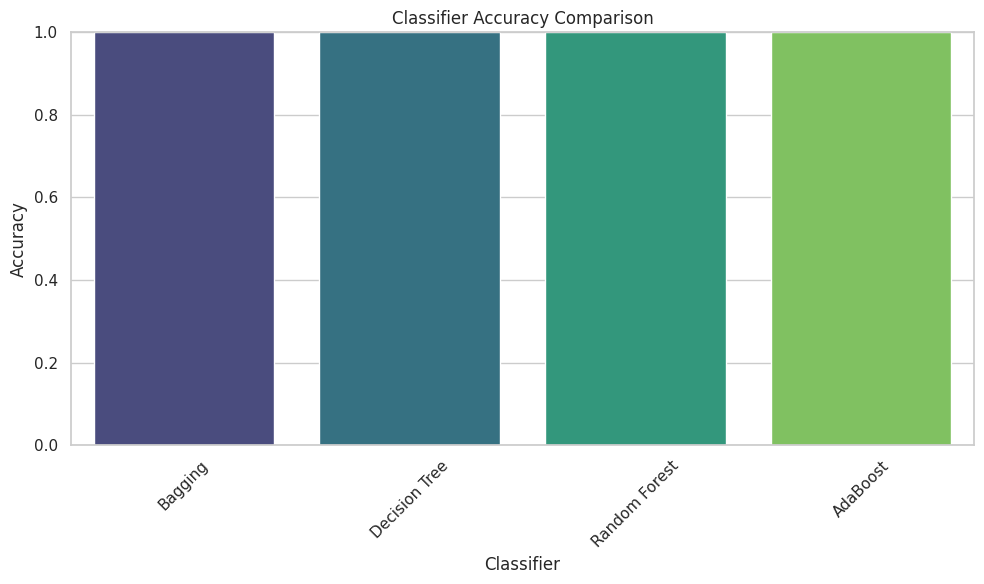

In [49]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=0.6, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, Y_train)
bag_y_pred = bag_clf.predict(X_test)

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, Y_train)
dt_y_pred = dt_clf.predict(X_test)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    learning_rate=1.0, random_state=42)
ab_clf.fit(X_train, Y_train)
ab_y_pred = ab_clf.predict(X_test)

# Calculate and plot the accuracy scores
bag_accuracy = accuracy_score(Y_test, bag_y_pred)
dt_accuracy = accuracy_score(Y_test, dt_y_pred)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
ab_accuracy = accuracy_score(Y_test, ab_y_pred)
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Decision Tree Classifier Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")
print(f"AdaBoost Classifier Accuracy: {ab_accuracy:.4f}")

# Plotting the accuracies
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
# Data for plotting
methods = ['Bagging', 'Decision Tree', 'Random Forest', 'AdaBoost']
accuracies = [bag_accuracy, dt_accuracy, rf_accuracy, ab_accuracy]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette="viridis")
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()